# Assignment 2: Semi-Gradient TD with a Neural Network

**Implement the following:**
 - Stochastic gradient descent for state-value prediction
 - Semi-gradient TD with a neural network as the function approximator and Adam Algorithm
 - Also, compare the performance of semi-gradient TD with a neural network and semi-gradinet TD with tile-coding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, shutil
from tqdm import tqdm
from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent
from optimizer import BaseOptimizer
import plot_script
from randomwalk_environment import RandomWalkEnvironment

## Section 1: Create semi-gradient TD with Neural Network

In this section, you will implement an Agent that learns with semi-gradient TD with a neural network. You will use a neural network with one hidden layer. The input of the neural network is the one-hot encoding of the state number. We use the one-hot encoding of the state number instead of the state number itself because we do not want to build the prior knowledge that integer number inputs close to each other have similar values. The hidden layer contains 100 rectifier linear units (ReLUs) which pass their input if it is bigger than one and return 0 otherwise. ReLU gates are commonly used in neural networks due to their nice properties such as the sparsity of the activation and having non-vanishing gradients. The output of the neural network is the estimated state value. It is a linear function of the hidden units as is commonly the case when estimating the value of a continuous target using neural networks.

The neural network looks like this: 
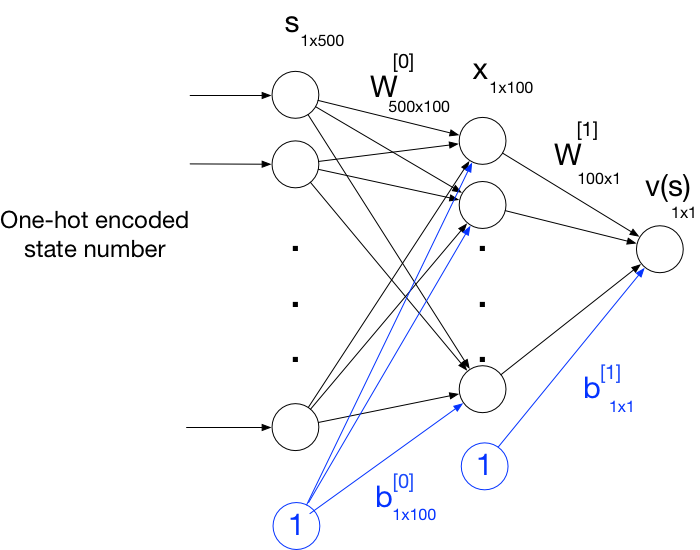


In [11]:
def my_matmul(x1, x2):
    """
    Given matrices x1 and x2, return their multiplication
    """
    result = np.zeros((x1.shape[0], x2.shape[1]))
    x1_non_zero_indices = x1.nonzero()
    if x1.shape[0] == 1 and len(x1_non_zero_indices[1]) == 1:
        result = x2[x1_non_zero_indices[1], :]
    elif x1.shape[1] == 1 and len(x1_non_zero_indices[0]) == 1:
        result[x1_non_zero_indices[0], :] = x2 * x1[x1_non_zero_indices[0], 0]
    else:
        result = np.matmul(x1, x2)
    return result

In [12]:
def get_value(s, weights):
    """
    Compute value of input s given the weights of a neural network
    """
    psi = my_matmul(s, weights[0]["W"]) + weights[0]["b"]
    x = np.maximum(0, psi)
    v = my_matmul(x, weights[1]["W"]) + weights[1]["b"]
    
    return v

In [13]:
num_hidden_layer = 1
s = np.array([[0, 0, 0, 1, 0]])

weights_data = np.load("asserts/get_value_weights.npz")
weights = [dict() for i in range(num_hidden_layer+1)]
weights[0]["W"] = weights_data["W0"]
weights[0]["b"] = weights_data["b0"]
weights[1]["W"] = weights_data["W1"]
weights[1]["b"] = weights_data["b1"]

estimated_value = get_value(s, weights)
print ("Estimated value: {}".format(estimated_value))
assert(np.allclose(estimated_value, np.array([[-0.21915705]])))

print ("Passed the assert!")

Estimated value: [[-0.21915705]]
Passed the assert!


In [16]:
def get_gradient(s, weights):
    """
    Given inputs s and weights, return the gradient of v with respect to the weights
    """
    
    grads = [dict() for i in range(len(weights))]
    
    psi = my_matmul(s, weights[0]["W"]) + weights[0]["b"]
    x = np.maximum(0, psi)
    I = (x > 0) * 1
    grads[0]["W"] = my_matmul(s.T, (weights[1]["W"].T * I))
    grads[0]["b"] = weights[1]["W"].T * I
    grads[1]["W"] = x.T
    grads[1]["b"] = 1
    
    return grads

In [17]:
num_hidden_layer = 1
s = np.array([[0, 0, 0, 1, 0]])

weights_data = np.load("asserts/get_gradient_weights.npz")
weights = [dict() for i in range(num_hidden_layer+1)]
weights[0]["W"] = weights_data["W0"]
weights[0]["b"] = weights_data["b0"]
weights[1]["W"] = weights_data["W1"]
weights[1]["b"] = weights_data["b1"]

grads = get_gradient(s, weights)

grads_answer = np.load("asserts/get_gradient_grads.npz")

print("grads[0][\"W\"]\n", grads[0]["W"], "\n")
print("grads[0][\"b\"]\n", grads[0]["b"], "\n")
print("grads[1][\"W\"]\n", grads[1]["W"], "\n")
print("grads[1][\"b\"]\n", grads[1]["b"], "\n")

assert(np.allclose(grads[0]["W"], grads_answer["W0"]))
assert(np.allclose(grads[0]["b"], grads_answer["b0"]))
assert(np.allclose(grads[1]["W"], grads_answer["W1"]))
assert(np.allclose(grads[1]["b"], grads_answer["b1"]))

print("Passed the asserts!")

grads[0]["W"]
 [[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.76103773 0.12167502]
 [0.         0.        ]] 

grads[0]["b"]
 [[0.76103773 0.12167502]] 

grads[1]["W"]
 [[0.69198983]
 [0.82403662]] 

grads[1]["b"]
 1 

Passed the asserts!


In [18]:
class SGD(BaseOptimizer):
    def __init__(self):
        pass
    
    def optimizer_init(self, optimizer_info):
        """Setup for the optimizer.

        Set parameters needed to setup the stochastic gradient descent method.

        Assume optimizer_info dict contains:
        {
            step_size: float
        }
        """
        self.step_size = optimizer_info.get("step_size")
        
    def update_weights(self, weights, g):
        """
        Given weights and update g, return updated weights
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
                weights[i][param] += self.step_size * g[i][param]
                
        return weights

In [19]:
num_hidden_layer = 1

weights_data = np.load("asserts/update_weights_weights.npz")
weights = [dict() for i in range(num_hidden_layer+1)]
weights[0]["W"] = weights_data["W0"]
weights[0]["b"] = weights_data["b0"]
weights[1]["W"] = weights_data["W1"]
weights[1]["b"] = weights_data["b1"]

g_data = np.load("asserts/update_weights_g.npz")
g = [dict() for i in range(num_hidden_layer+1)]
g[0]["W"] = g_data["W0"]
g[0]["b"] = g_data["b0"]
g[1]["W"] = g_data["W1"]
g[1]["b"] = g_data["b1"]

test_sgd = SGD()
optimizer_info = {"step_size": 0.3}
test_sgd.optimizer_init(optimizer_info)
updated_weights = test_sgd.update_weights(weights, g)

# updated weights asserts
updated_weights_answer = np.load("asserts/update_weights_updated_weights.npz")

print("updated_weights[0][\"W\"]\n", updated_weights[0]["W"], "\n")
print("updated_weights[0][\"b\"]\n", updated_weights[0]["b"], "\n")
print("updated_weights[1][\"W\"]\n", updated_weights[1]["W"], "\n")
print("updated_weights[1][\"b\"]\n", updated_weights[1]["b"], "\n")

assert(np.allclose(updated_weights[0]["W"], updated_weights_answer["W0"]))
assert(np.allclose(updated_weights[0]["b"], updated_weights_answer["b0"]))
assert(np.allclose(updated_weights[1]["W"], updated_weights_answer["W1"]))
assert(np.allclose(updated_weights[1]["b"], updated_weights_answer["b1"]))

print("Passed the asserts!")

updated_weights[0]["W"]
 [[ 1.17899492  0.53656321]
 [ 0.58008221  1.47666572]
 [ 1.01909411 -1.10248056]
 [ 0.72490408  0.06828853]
 [-0.20609725  0.69034095]] 

updated_weights[0]["b"]
 [[-0.18484533  0.92844539]] 

updated_weights[1]["W"]
 [[0.70488257]
 [0.58150878]] 

updated_weights[1]["b"]
 [[0.88467086]] 

Passed the asserts!


In [20]:
class Adam(BaseOptimizer):
    def __init__(self):
        pass
    
    def optimizer_init(self, optimizer_info):
        """Setup for the optimizer.

        Set parameters needed to setup the Adam algorithm.

        Assume optimizer_info dict contains:
        {
            num_states: integer,
            num_hidden_layer: integer,
            num_hidden_units: integer,
            step_size: float, 
            self.beta_m: float
            self.beta_v: float
            self.epsilon: float
        }
        """
        self.num_states = optimizer_info.get("num_states")
        self.num_hidden_layer = optimizer_info.get("num_hidden_layer")
        self.num_hidden_units = optimizer_info.get("num_hidden_units")
        
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")
        

        self.layer_size = np.array([self.num_states, self.num_hidden_units, 1])
        
        self.m = [dict() for i in range(self.num_hidden_layer+1)]
        self.v = [dict() for i in range(self.num_hidden_layer+1)]
        
        for i in range(self.num_hidden_layer+1):
            self.m[i]["W"] = np.zeros((self.layer_size[i], self.layer_size[i+1]))
            self.m[i]["b"] = np.zeros((1, self.layer_size[i+1]))
            self.v[i]["W"] = np.zeros((self.layer_size[i], self.layer_size[i+1]))
            self.v[i]["b"] = np.zeros((1, self.layer_size[i+1]))
            
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v
        
    def update_weights(self, weights, g):
        """
        Given weights and update g, return updated weights
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
                self.m[i][param] = self.beta_m * self.m[i][param] + (1 - self.beta_m) * g[i][param]
                self.v[i][param] = self.beta_v * self.v[i][param] + (1 - self.beta_v) * (g[i][param] * g[i][param])
                
                m_hat = self.m[i][param] / (1 - self.beta_m_product)
                v_hat = self.v[i][param] / (1 - self.beta_v_product)
                
                weights[i][param] += self.step_size * m_hat / (np.sqrt(v_hat) + self.epsilon)
                
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v
        
        return weights

In [21]:
def one_hot(state, num_states):
    """
    Given num_state and a state, return the one-hot encoding of the state
    """
    one_hot_vector = np.zeros((1, num_states))
    one_hot_vector[0, int((state -1 ))] = 1
    
    return one_hot_vector

In [22]:
class TDAgent(BaseAgent):
    def __init__(self):
        self.name = "td_agent"
        pass
    
    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD with a Neural Network.

        Assume agent_info dict contains:
        {
            num_states: integer,
            num_hidden_layer: integer,
            num_hidden_units: integer,
            step_size: float, 
            discount_factor: float,
            self.beta_m: float
            self.beta_v: float
            self.epsilon: float
            seed: int
        }
        """
        
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        
        self.policy_rand_generator = np.random.RandomState(agent_info.get("seed"))
        
        self.num_states = agent_info.get("num_states")
        self.num_hidden_layer = agent_info.get("num_hidden_layer")
        self.num_hidden_units = agent_info.get("num_hidden_units")
        self.discount_factor = agent_info.get("discount_factor")
        
        self.layer_size = np.array([self.num_states, self.num_hidden_units, self.num_hidden_layer])
        
        self.weights = [dict() for i in range(self.num_hidden_layer+1)]
        for i in range(self.num_hidden_layer+1):
            input_size, output_size = self.layer_size[i], self.layer_size[i+1]
            self.weights[i]["W"] = self.rand_generator.normal(0, np.sqrt(2/input_size), (input_size, output_size))
            self.weights[i]["b"] = self.rand_generator.normal(0, np.sqrt(2/input_size), (1, output_size))
            
        self.optimizer = Adam()
        optimizer_info = {"num_states": agent_info["num_states"],
                          "num_hidden_layer": agent_info["num_hidden_layer"],
                          "num_hidden_units": agent_info["num_hidden_units"],
                          "step_size": agent_info["step_size"],
                          "beta_m": agent_info["beta_m"],
                          "beta_v": agent_info["beta_v"],
                          "epsilon": agent_info["epsilon"]}
        self.optimizer.optimizer_init(optimizer_info)
        
        self.last_state = None
        self.last_action = None
        
    def agent_policy(self, state):
        chosen_action = self.policy_rand_generator.choice([0,1])    
        return chosen_action
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        action = self.agent_policy(state)
        self.last_state = state
        self.last_action = action
        
        return self.last_action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        last_state_vector = one_hot(self.last_state, self.num_states)
        last_value = get_value(last_state_vector, self.weights)
        current_state_vector = one_hot(state, self.num_states)
        current_value = get_value(current_state_vector, self.weights)
        delta = reward + self.discount_factor * current_value - last_value
        
        grads = get_gradient(last_state_vector, self.weights)
        
        g = [dict() for i in range(self.num_hidden_layer+1)]
        for i in range(self.num_hidden_layer+1):
            for param in self.weights[i].keys():
                g[i][param] = delta * grads[i][param]
                
        self.weights = self.optimizer.update_weights(self.weights, g)
        
        action = self.agent_policy(state)
        self.last_state = state
        self.last_action = action
        
        return self.last_action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        last_state_vector = one_hot(self.last_state, self.num_states)
        last_value = get_value(last_state_vector, self.weights)
        
        delta = reward - last_value
        
        grads = get_gradient(last_state_vector, self.weights)
        
        g = [dict() for i in range(self.num_hidden_layer+1)]
        for i in range(self.num_hidden_layer+1):
            for param in self.weights[i].keys():
                g[i][param] = delta * grads[i][param]
                
        self.weights = self.optimizer.update_weights(self.weights, g)
        
    def agent_message(self, message):
        if message == 'get state value':
            state_value = np.zeros(self.num_states)
            for state in range(1, self.num_states + 1):
                s = one_hot(state, self.num_states)
                state_value[state - 1] = get_value(s, self.weights)
            return state_value

In [23]:
## Test Code for agent_init() ## 

agent_info = {"num_states": 5,
              "num_hidden_layer": 1,
              "num_hidden_units": 2,
              "step_size": 0.25,
              "discount_factor": 0.9,
              "beta_m": 0.9,
              "beta_v": 0.99,
              "epsilon": 0.0001,
              "seed": 0
             }

test_agent = TDAgent()
test_agent.agent_init(agent_info)

print("layer_size: {}".format(test_agent.layer_size))
assert(np.allclose(test_agent.layer_size, np.array([agent_info["num_states"], 
                                                    agent_info["num_hidden_units"], 
                                                    1])))

print("weights[0][\"W\"] shape: {}".format(test_agent.weights[0]["W"].shape))
print("weights[0][\"b\"] shape: {}".format(test_agent.weights[0]["b"].shape))
print("weights[1][\"W\"] shape: {}".format(test_agent.weights[1]["W"].shape))
print("weights[1][\"b\"] shape: {}".format(test_agent.weights[1]["b"].shape), "\n")

assert(test_agent.weights[0]["W"].shape == (agent_info["num_states"], agent_info["num_hidden_units"]))
assert(test_agent.weights[0]["b"].shape == (1, agent_info["num_hidden_units"]))
assert(test_agent.weights[1]["W"].shape == (agent_info["num_hidden_units"], 1))
assert(test_agent.weights[1]["b"].shape == (1, 1))

print("weights[0][\"W\"]\n", (test_agent.weights[0]["W"]), "\n")
print("weights[0][\"b\"]\n", (test_agent.weights[0]["b"]), "\n")
print("weights[1][\"W\"]\n", (test_agent.weights[1]["W"]), "\n")
print("weights[1][\"b\"]\n", (test_agent.weights[1]["b"]), "\n")


agent_weight_answer = np.load("asserts/agent_init_weights_1.npz")
assert(np.allclose(test_agent.weights[0]["W"], agent_weight_answer["W0"]))
assert(np.allclose(test_agent.weights[0]["b"], agent_weight_answer["b0"]))
assert(np.allclose(test_agent.weights[1]["W"], agent_weight_answer["W1"]))
assert(np.allclose(test_agent.weights[1]["b"], agent_weight_answer["b1"]))

print("Passed the asserts!")

layer_size: [5 2 1]
weights[0]["W"] shape: (5, 2)
weights[0]["b"] shape: (1, 2)
weights[1]["W"] shape: (2, 1)
weights[1]["b"] shape: (1, 1) 

weights[0]["W"]
 [[ 1.11568467  0.25308164]
 [ 0.61900825  1.4172653 ]
 [ 1.18114738 -0.6180848 ]
 [ 0.60088868 -0.0957267 ]
 [-0.06528133  0.25968529]] 

weights[0]["b"]
 [[0.09110115 0.91976332]] 

weights[1]["W"]
 [[0.76103773]
 [0.12167502]] 

weights[1]["b"]
 [[0.44386323]] 

Passed the asserts!


In [24]:
# Do not modify this cell!

## Test Code for agent_start() ## 

agent_info = {"num_states": 500,
              "num_hidden_layer": 1,
              "num_hidden_units": 100,
              "step_size": 0.1,
              "discount_factor": 1.0,
              "beta_m": 0.9,
              "beta_v": 0.99,
              "epsilon": 0.0001,
              "seed": 10
             }

# Suppose state = 250
state = 250

test_agent = TDAgent()
test_agent.agent_init(agent_info)
test_agent.agent_start(state)

print("Agent state: {}".format(test_agent.last_state))
print("Agent selected action: {}".format(test_agent.last_action))

assert(test_agent.last_state == 250)
assert(test_agent.last_action == 1)

print("Passed the asserts!")

Agent state: 250
Agent selected action: 1
Passed the asserts!


In [25]:
# Do not modify this cell!

## Test Code for agent_step() ## 

agent_info = {"num_states": 5,
              "num_hidden_layer": 1,
              "num_hidden_units": 2,
              "step_size": 0.1,
              "discount_factor": 1.0,
              "beta_m": 0.9,
              "beta_v": 0.99,
              "epsilon": 0.0001,
              "seed": 0
             }

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# load initial weights
agent_initial_weight = np.load("asserts/agent_step_initial_weights.npz")
test_agent.weights[0]["W"] = agent_initial_weight["W0"]
test_agent.weights[0]["b"] = agent_initial_weight["b0"]
test_agent.weights[1]["W"] = agent_initial_weight["W1"]
test_agent.weights[1]["b"] = agent_initial_weight["b1"]

# load m and v for the optimizer
m_data = np.load("asserts/agent_step_initial_m.npz")
test_agent.optimizer.m[0]["W"] = m_data["W0"]
test_agent.optimizer.m[0]["b"] = m_data["b0"]
test_agent.optimizer.m[1]["W"] = m_data["W1"]
test_agent.optimizer.m[1]["b"] = m_data["b1"]

v_data = np.load("asserts/agent_step_initial_v.npz")
test_agent.optimizer.v[0]["W"] = v_data["W0"]
test_agent.optimizer.v[0]["b"] = v_data["b0"]
test_agent.optimizer.v[1]["W"] = v_data["W1"]
test_agent.optimizer.v[1]["b"] = v_data["b1"]

# Assume the agent started at State 3
start_state = 3
test_agent.agent_start(start_state)

# Assume the reward was 10.0 and the next state observed was State 1
reward = 10.0
next_state = 1
test_agent.agent_step(reward, next_state)

# updated weights asserts
print("updated_weights[0][\"W\"]\n", test_agent.weights[0]["W"], "\n")
print("updated_weights[0][\"b\"]\n", test_agent.weights[0]["b"], "\n")
print("updated_weights[1][\"W\"]\n", test_agent.weights[1]["W"], "\n")
print("updated_weights[1][\"b\"]\n", test_agent.weights[1]["b"], "\n")

agent_updated_weight_answer = np.load("asserts/agent_step_updated_weights.npz")
assert(np.allclose(test_agent.weights[0]["W"], agent_updated_weight_answer["W0"]))
assert(np.allclose(test_agent.weights[0]["b"], agent_updated_weight_answer["b0"]))
assert(np.allclose(test_agent.weights[1]["W"], agent_updated_weight_answer["W1"]))
assert(np.allclose(test_agent.weights[1]["b"], agent_updated_weight_answer["b1"]))

# last_state and last_action assert
print("Agent last state:", test_agent.last_state)
print("Agent last action:", test_agent.last_action, "\n")

assert(test_agent.last_state == 1)
assert(test_agent.last_action == 1)

print ("Passed the asserts!")

updated_weights[0]["W"]
 [[ 1.10893459  0.30763738]
 [ 0.63690565  1.14778865]
 [ 1.23397791 -0.48152743]
 [ 0.72792093 -0.15829832]
 [ 0.15021996  0.39822163]] 

updated_weights[0]["b"]
 [[0.29798822 0.96254535]] 

updated_weights[1]["W"]
 [[0.76628754]
 [0.11486511]] 

updated_weights[1]["b"]
 [[0.58530057]] 

Agent last state: 1
Agent last action: 1 

Passed the asserts!


In [26]:
# Do not modify this cell!

## Test Code for agent_end() ## 

agent_info = {"num_states": 5,
              "num_hidden_layer": 1,
              "num_hidden_units": 2,
              "step_size": 0.1,
              "discount_factor": 1.0,
              "beta_m": 0.9,
              "beta_v": 0.99,
              "epsilon": 0.0001,
              "seed": 0
             }

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# load initial weights
agent_initial_weight = np.load("asserts/agent_end_initial_weights.npz")
test_agent.weights[0]["W"] = agent_initial_weight["W0"]
test_agent.weights[0]["b"] = agent_initial_weight["b0"]
test_agent.weights[1]["W"] = agent_initial_weight["W1"]
test_agent.weights[1]["b"] = agent_initial_weight["b1"]

# load m and v for the optimizer
m_data = np.load("asserts/agent_step_initial_m.npz")
test_agent.optimizer.m[0]["W"] = m_data["W0"]
test_agent.optimizer.m[0]["b"] = m_data["b0"]
test_agent.optimizer.m[1]["W"] = m_data["W1"]
test_agent.optimizer.m[1]["b"] = m_data["b1"]

v_data = np.load("asserts/agent_step_initial_v.npz")
test_agent.optimizer.v[0]["W"] = v_data["W0"]
test_agent.optimizer.v[0]["b"] = v_data["b0"]
test_agent.optimizer.v[1]["W"] = v_data["W1"]
test_agent.optimizer.v[1]["b"] = v_data["b1"]

# Assume the agent started at State 4
start_state = 4
test_agent.agent_start(start_state)

# Assume the reward was 10.0 and reached the terminal state
reward = 10.0
test_agent.agent_end(reward)

# updated weights asserts
print("updated_weights[0][\"W\"]\n", test_agent.weights[0]["W"], "\n")
print("updated_weights[0][\"b\"]\n", test_agent.weights[0]["b"], "\n")
print("updated_weights[1][\"W\"]\n", test_agent.weights[1]["W"], "\n")
print("updated_weights[1][\"b\"]\n", test_agent.weights[1]["b"], "\n")

agent_updated_weight_answer = np.load("asserts/agent_end_updated_weights.npz")
assert(np.allclose(test_agent.weights[0]["W"], agent_updated_weight_answer["W0"]))
assert(np.allclose(test_agent.weights[0]["b"], agent_updated_weight_answer["b0"]))
assert(np.allclose(test_agent.weights[1]["W"], agent_updated_weight_answer["W1"]))
assert(np.allclose(test_agent.weights[1]["b"], agent_updated_weight_answer["b1"]))

print ("Passed the asserts!")

updated_weights[0]["W"]
 [[ 1.10893459  0.30763738]
 [ 0.63690565  1.14778865]
 [ 1.17531054 -0.51043162]
 [ 0.75062903 -0.13736817]
 [ 0.15021996  0.39822163]] 

updated_weights[0]["b"]
 [[0.30846523 0.95937346]] 

updated_weights[1]["W"]
 [[0.68861703]
 [0.15986364]] 

updated_weights[1]["b"]
 [[0.586074]] 

Passed the asserts!


## Section 2: Run Experiment

In [27]:
true_state_val = np.load('data/true_V.npy')    
state_distribution = np.load('data/state_distribution.npy')

def calc_RMSVE(learned_state_val):
    assert(len(true_state_val) == len(learned_state_val) == len(state_distribution))
    MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
    RMSVE = np.sqrt(MSVE)
    return RMSVE

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Setting - Neural Network with 100 hidden units


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [12:36<00:00, 37.84s/it]


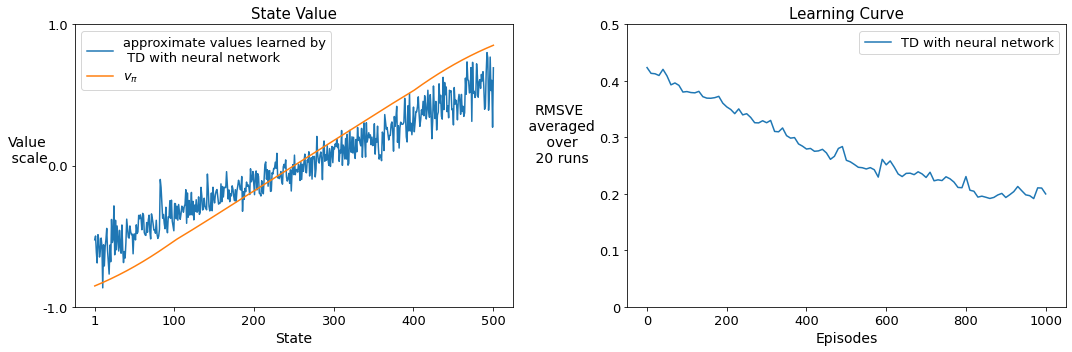

'C:\\Users\\anura\\Desktop\\RL spec\\Prediction_and_Control_with_Functional_Approximation\\Week 2\\results.zip'

In [28]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
    
    agent_rmsve = np.zeros((experiment_parameters["num_runs"], 
                            int(experiment_parameters["num_episodes"]/experiment_parameters["episode_eval_frequency"]) + 1))
    
    agent_state_val = np.zeros((experiment_parameters["num_runs"], 
                                environment_parameters["num_states"]))
    
    env_info = {"num_states": environment_parameters["num_states"],
                "start_state": environment_parameters["start_state"],
                "left_terminal_state": environment_parameters["left_terminal_state"],
                "right_terminal_state": environment_parameters["right_terminal_state"]}
    
    agent_info = {"num_states": environment_parameters["num_states"],
                  "num_hidden_layer": agent_parameters["num_hidden_layer"],
                  "num_hidden_units": agent_parameters["num_hidden_units"],
                  "step_size": agent_parameters["step_size"],
                  "discount_factor": environment_parameters["discount_factor"],
                  "beta_m": agent_parameters["beta_m"],
                  "beta_v": agent_parameters["beta_v"],
                  "epsilon": agent_parameters["epsilon"]
                 }
    
    print('Setting - Neural Network with 100 hidden units')
    os.system('sleep 1')
    
    for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
        env_info["seed"] = run
        agent_info["seed"] = run
        rl_glue.rl_init(agent_info, env_info)
        
        current_V = rl_glue.rl_agent_message("get state value")
        agent_rmsve[run-1, 0] = calc_RMSVE(current_V)
        
        for episode in range(1, experiment_parameters["num_episodes"]+1):
            rl_glue.rl_episode(0)
            
            if episode % experiment_parameters["episode_eval_frequency"] == 0:
                current_V = rl_glue.rl_agent_message("get state value")
                agent_rmsve[run-1, int(episode/experiment_parameters["episode_eval_frequency"])] = calc_RMSVE(current_V)
            elif episode == experiment_parameters["num_episodes"]: # if last episode
                current_V = rl_glue.rl_agent_message("get state value")
                
        agent_state_val[run-1, :] = current_V
        
    save_name = "{}".format(rl_glue.agent.name).replace('.','')
    
    if not os.path.exists('results'):
        os.makedirs('results')
        
    np.save("results/V_{}".format(save_name), agent_state_val)
    
    np.savez("results/RMSVE_{}".format(save_name), rmsve = agent_rmsve,
                                                   eval_freq = experiment_parameters["episode_eval_frequency"],
                                                   num_episodes = experiment_parameters["num_episodes"])
    
# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 20,
    "num_episodes" : 1000,
    "episode_eval_frequency" : 10 # evaluate every 10 episode
}

# Environment parameters
environment_parameters = {
    "num_states" : 500,
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501,
    "discount_factor" : 1.0
}

# Agent parameters
agent_parameters = {
    "num_hidden_layer": 1,
    "num_hidden_units": 100,
    "step_size": 0.001,
    "beta_m": 0.9,
    "beta_v": 0.999,
    "epsilon": 0.0001,
}

current_env = RandomWalkEnvironment
current_agent = TDAgent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

# plot result
plot_script.plot_result(["td_agent"])

shutil.make_archive('results', 'zip', 'results')

You plotted the learning curve for 1000 episodes. As you can see the RMSVE is still decreasing. Here we provide the pre-computed result for 5000 episodes and 20 runs so that you can see the performance of semi-gradient TD with a neural network after being trained for a long time.
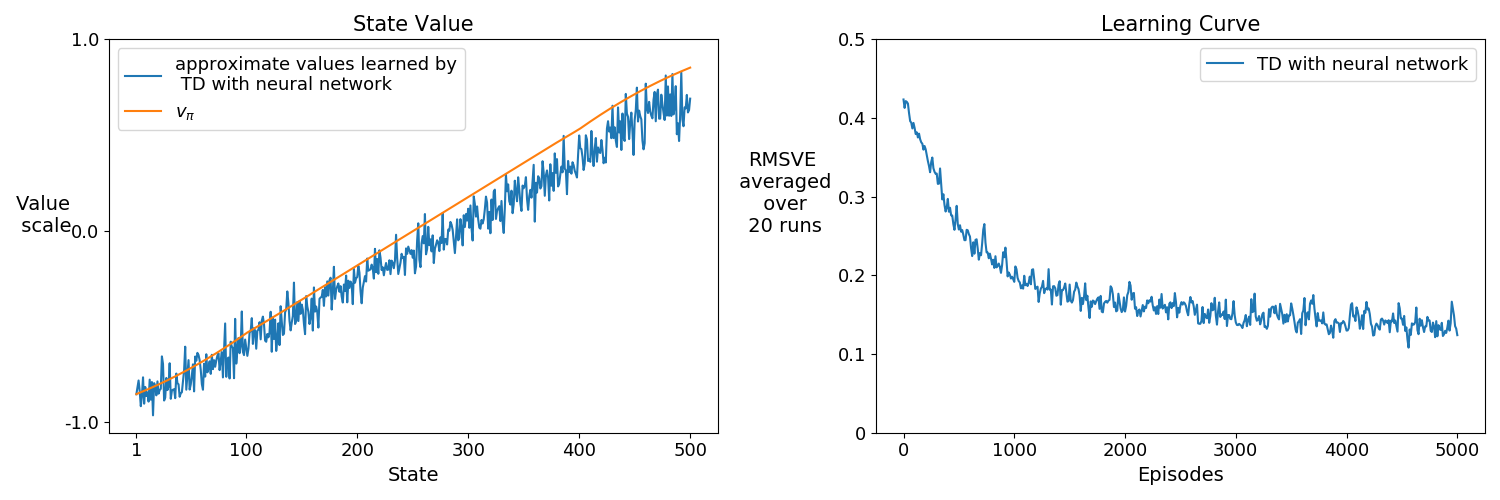

In this section, we compare the performance of semi-gradient TD with a Neural Network and semi-gradient TD with tile-coding. Tile-coding is a kind of coarse coding that uses multiple overlapping partitions of the state space to produce features. For tile-coding, we used 50 tilings each with 6 tiles. We set the step-size for semi-gradient TD with tile-coding to $\frac{0.1}{\text{# tilings}}$. See the figure below for the comparison between semi-gradient TD with tile-coding and semi-gradient TD with a neural network and Adam algorithm. This result is for 5000 episodes and 20 runs: 

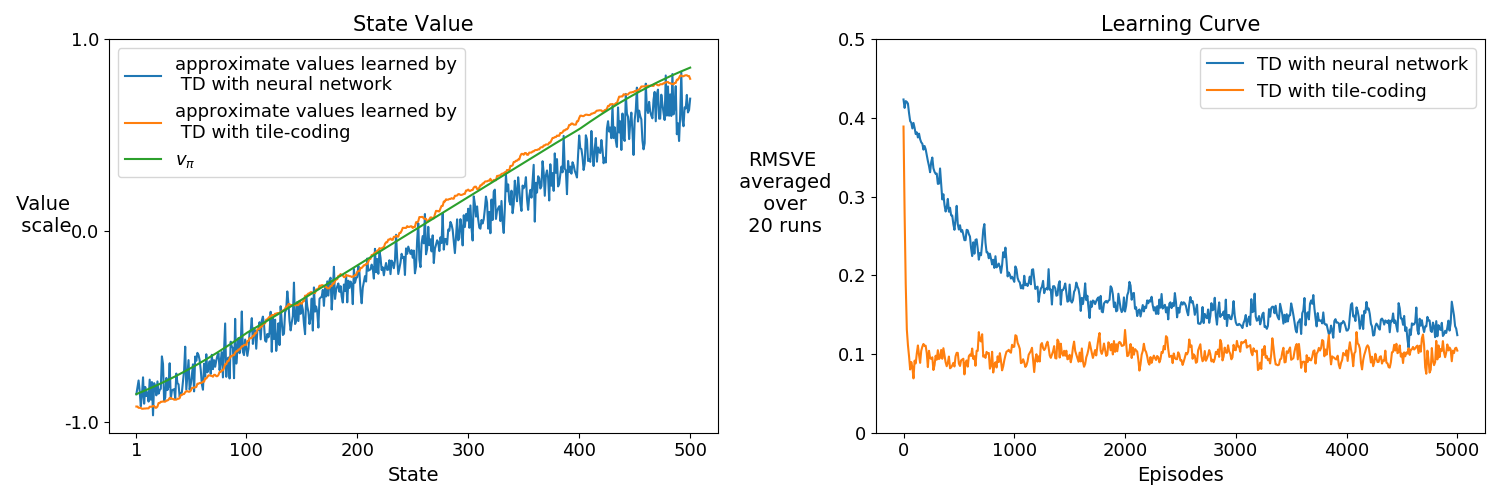